In [64]:
%reset

In [65]:
# 加载所需的库
import pandas as pd
import numpy as np
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import chi2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime

In [66]:
#设置参数
m = 100
l = pd.Series(np.repeat(1,m))
Delta = 1.7
d = 5
Rho = 0.5
n = 300
np.random.seed(1)

## crude simulation
最原始的仿真方法，作为benchmark使用，与后文的4种方法进行比较。

In [67]:
np.random.seed(1)
CS_starttime = datetime.datetime.now()

P_crude = list()

for j in range(100):
    L_crude = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) / np.power(Chi_2/d,0.5)
        L_crude.append(np.sum(l*(x>Delta)))

    L_crude = pd.Series(L_crude)
    p = sum(L_crude>10)/len(L_crude)
    P_crude.append(p)

P_crude = pd.Series(P_crude)

CS_endtime = datetime.datetime.now()
CS_time = CS_endtime-CS_starttime

(array([ 2.,  7.,  7., 13., 11., 19., 17., 12.,  7.,  5.]),
 array([0.18      , 0.19133333, 0.20266667, 0.214     , 0.22533333,
        0.23666667, 0.248     , 0.25933333, 0.27066667, 0.282     ,
        0.29333333]),
 <BarContainer object of 10 artists>)

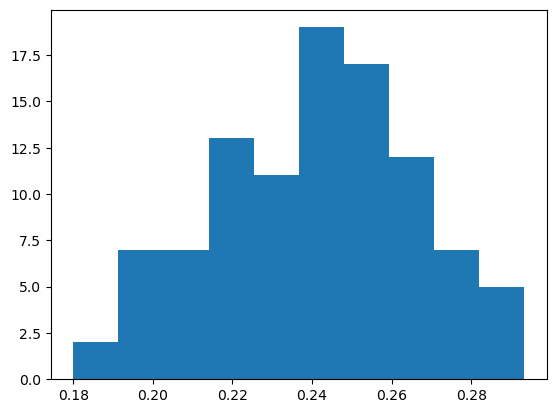

In [68]:
plt.hist(P_crude)

In [69]:
print('均值为',np.mean(P_crude),'\n',
      '方差为：',np.var(P_crude),'\n',
      '运行时间为：',CS_time)

均值为 0.2408 
 方差为： 0.0006626933333333337 
 运行时间为： 0:00:06.497823


## Antithetic Variates
方法1：效果一般，方差减少为初始方法的1/4,时间为两倍。

In [70]:
np.random.seed(1)
AV_starttime = datetime.datetime.now()

P_AV = list()

for j in range(100):
    p_AV = list()
    for i in range(n):
        #生成仿真
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) \
            / np.power(Chi_2/d,0.5)
        L=np.sum(l*(x>Delta))
        if L > 10:
            p = 1
        else:
            p=0

        #生成Antithetic
        Chi_2_anti = chi2.ppf(q=(1-u), df=d)
        x_anti = (Rho*(-z_0) + np.power((1-np.power(Rho,2)),0.5)*(-z)) \
                 / np.power(Chi_2_anti/d,0.5)
        L_anty = np.sum(l*(x_anti>Delta))
        if L_anty > 10:
            p_anty = 1
        else:
            p_anty=0

        #记录
        p_AV.append((p+p_anty)/2)

    p = np.mean(p_AV)
    P_AV.append(p)

P_AV = pd.Series(P_AV)

AV_endtime = datetime.datetime.now()
AV_time = AV_endtime-AV_starttime

(array([ 4.,  8.,  7., 20., 14., 18., 14.,  9.,  4.,  2.]),
 array([0.20833333, 0.21466667, 0.221     , 0.22733333, 0.23366667,
        0.24      , 0.24633333, 0.25266667, 0.259     , 0.26533333,
        0.27166667]),
 <BarContainer object of 10 artists>)

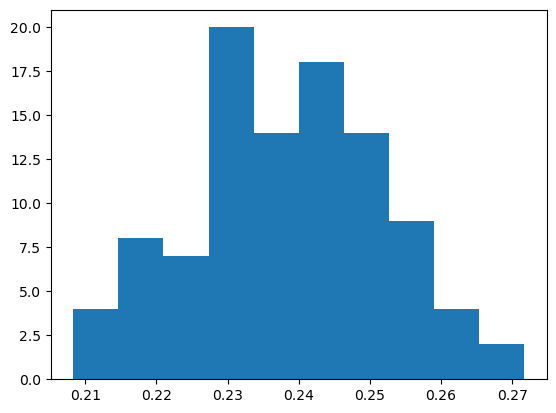

In [71]:
plt.hist(P_AV)

In [72]:
print('均值为',np.mean(P_AV),'\n',
      '方差为：',np.var(p_AV),'\n',
      '运行时间为：',AV_time,'\n',
      '方差比例为：',np.var(P_AV)/np.var(P_crude),'\n',
      '时间比例为：',AV_time/CS_time)

均值为 0.2382 
 方差为： 0.060899999999999996 
 运行时间为： 0:00:12.858060 
 方差比例为： 0.2656398803535738 
 时间比例为： 1.9788258313592106


## Control variates
方法2：效果较差，方差减少为初始方法的3/4，时间为初始方法的两倍。

In [73]:
np.random.seed(1)
CV_starttime = datetime.datetime.now()

P_CV = list()

for j in range(100):
    L_CV = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) / np.power(Chi_2/d,0.5)
        L = np.sum(l*(x>Delta))
        if L > 10:
            p = 1
        else:
            p=0

        L_CV.append([p]+[z_0]+[Chi_2-d]+list(z))

        #L_CV.insert(L_CV.shape[1],i,[L]+[z_0]+list(Chi_2-d)+list(z))

    L_CV = pd.DataFrame(L_CV)

    y = L_CV.iloc[:, 0] # 因变量
    x = L_CV.iloc[:, 1:] # 自变量

    model = LinearRegression() # 构建线性模型
    model.fit(x, y) # 自变量在前，因变量在后
    predicts = model.predict(x)
    intercept = model.intercept_
    r = y - predicts + intercept

    p = np.mean(r)
    P_CV.append(p)

P_CV = pd.Series(P_CV)

CV_endtime = datetime.datetime.now()
CV_time = CV_endtime-CV_starttime

(array([ 4.,  8., 15., 23., 15., 14.,  6.,  6.,  5.,  4.]),
 array([0.18840696, 0.19860719, 0.20880741, 0.21900763, 0.22920786,
        0.23940808, 0.2496083 , 0.25980853, 0.27000875, 0.28020897,
        0.2904092 ]),
 <BarContainer object of 10 artists>)

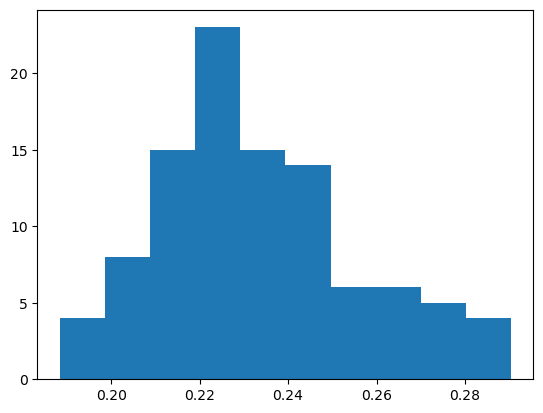

In [74]:
plt.hist(P_CV)

In [75]:
print('均值为',np.mean(P_CV),'\n',
      '方差为：',np.var(P_CV),'\n',
      '运行时间为：',CV_time,'\n',
      '方差比例为：',np.var(P_CV)/np.var(P_crude),'\n',
      '时间比例为：',CV_time/CS_time)

均值为 0.23327976262877523 
 方差为： 0.0005027419197397793 
 运行时间为： 0:00:11.968204 
 方差比例为： 0.7586343402777237 
 时间比例为： 1.8418790416421007


## CONDITIONAL EXPECTATIONS
方法3、4:条件期望的框架下，提供了两种不同的仿真方法。
两种的效果均相对较好，在时间为原始方法1/2的情况下，方差为原始方法的4/5与2/5。
但值得注意的是，虽然方法3在理论推倒上非常顺畅，但方法3的点估计出现了一定的偏误，因此应当是不可用的。
所以，将方法3保留下来仅作为参考，方便后续讨论寻找问题，。

In [85]:
np.random.seed(1)
CE_starttime = datetime.datetime.now()

P_CE = list()

for j in range(100):
    p_CE = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)

        y = (Delta * np.power(Chi_2/d,0.5) - Rho*z_0 ) / np.power((1-np.power(Rho,2)),0.5)
        p_binom = 1 - norm.cdf(y)
        p = 1 - binom.cdf(9,n=100,p=p_binom)

        p_CE.append(p)

    p = np.mean(p_CE)
    P_CE.append(p)

P_CE = pd.Series(P_CE)

CE_endtime = datetime.datetime.now()
CE_time = CE_endtime-CE_starttime


(array([ 1.,  4.,  6., 13., 21., 21., 17., 12.,  3.,  2.]),
 array([0.19180428, 0.20471469, 0.21762511, 0.23053552, 0.24344594,
        0.25635636, 0.26926677, 0.28217719, 0.2950876 , 0.30799802,
        0.32090844]),
 <BarContainer object of 10 artists>)

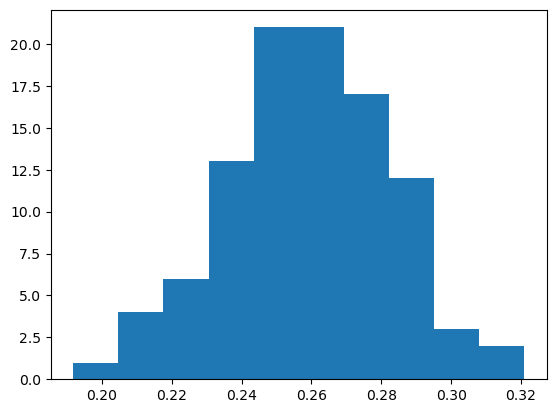

In [86]:
plt.hist(P_CE)

In [87]:
print('均值为',np.mean(P_CE),'\n',
      '方差为：',np.var(P_CE),'\n',
      '运行时间为：',CE_time,'\n',
      '方差比例为：',np.var(P_CE)/np.var(P_crude),'\n',
      '时间比例为：',CE_time/CS_time)

均值为 0.2592993113864054 
 方差为： 0.0005559610125327594 
 运行时间为： 0:00:02.779108 
 方差比例为： 0.8389416107995037 
 时间比例为： 0.427698322961398


In [79]:
np.random.seed(1)
CE2_starttime = datetime.datetime.now()

P_CE2 = list()
cutoff = norm.ppf(1-10/m)

for j in range(100):
    p_CE2 = list()

    for i in range(3*n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)

        y = (Delta * np.power(Chi_2/d,0.5) - Rho*z_0 ) / np.power((1-np.power(Rho,2)),0.5)
        if y < cutoff:
            p = 1
        else:
            p = 0

        p_CE2.append(p)

    p = np.mean(p_CE2)
    P_CE2.append(p)

P_CE2 = pd.Series(P_CE2)

CE2_endtime = datetime.datetime.now()
CE2_time = CE2_endtime-CE2_starttime

(array([ 2.,  3.,  8., 12., 24., 17., 21.,  8.,  4.,  1.]),
 array([0.20111111, 0.20977778, 0.21844444, 0.22711111, 0.23577778,
        0.24444444, 0.25311111, 0.26177778, 0.27044444, 0.27911111,
        0.28777778]),
 <BarContainer object of 10 artists>)

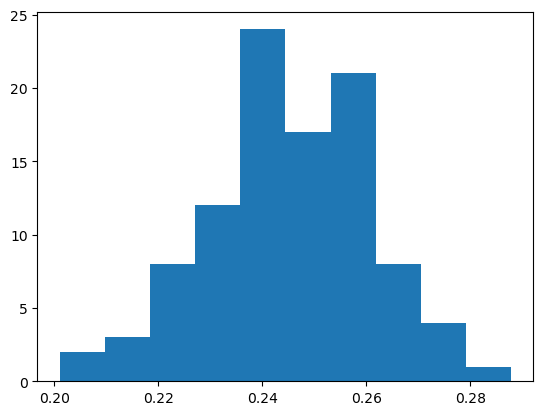

In [80]:
plt.hist(P_CE2)

In [81]:
print('均值为',np.mean(P_CE2),'\n',
      '方差为：',np.var(P_CE2),'\n',
      '运行时间为：',CE2_time,'\n',
      '方差比例为：',np.var(P_CE2)/np.var(P_crude),'\n',
      '时间比例为：',CE2_time/CS_time)


均值为 0.24544444444444463 
 方差为： 0.00026062962962962964 
 运行时间为： 0:00:03.179889 
 方差比例为： 0.39328844356811016 
 时间比例为： 0.48937759615797477
